# CNN   small datasets 학습


- 학습 Data양이 많지 않을 때 CNN을 통한 모델 학습이 어려울 수 있다.
    - CNN모델 뿐 아니라 딥러닝 모델은 대량의 데이터셋을 학습해야 좋은 성능을 낼 수 있다.
- 학습 시킬 Data 양이 많지 않아 딥러닝 모델의 학습에 어려움이 있을 때 다음과 같은 방법을 이용해 모델 성능을 높일 수있다.
    - **Data augmentation 활용**
        - Image에 다양한 효과를 주어 그럴듯한 변형 데이터들을 생성해서 데이터양을 늘린다.
            - Train dataset은 전체 대상 이미지들을 샘플링한 것이기 때문에 모든 형태를 다 가지고 있지 않다. Data augmentation은 train set의 이미지에 다양한 효과를 주어 실제 데이터셋과의 간격을 줄인다.
            - 영상데이터의 경우 각 영상 데이터의 색변경, 이미지잘라내기, 회전시키기, 명암변경 등을 적용하여 이미지들을 추가로 만들어 data의 수를 늘린다.
        - **모델의 Overfitting을 개선시킨다.**
        - pytorch image augmentation을 위한 클래스들
            - https://pytorch.org/vision/stable/transforms.html
            - https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
    - **Pre-trained network**의 활용한 **Transfer learning (전이학습)**
        - 매우 큰 데이터셋으로 미리 Training한 모델을 이용해 모델을 정의한다.
        - 성능이 좋은모델을 다량의 데이터로 학습시킨 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

# Image Augmentation 예제

In [ ]:
%pip install opencv-python

In [2]:
import torch
from torchvision import transforms

import cv2 # opencv 모듈듈
import matplotlib.pyplot as plt

In [15]:
# 이미지 출력 함수
def image_show(img_path, transforms):
    """
    이미지 경로와 transforms를 받아서 적용한뒤 원본이미지와 처리된 이미지를 출력한다.
    [parameter]
        img_path: str - transforms를 적용할 이미지 경로
        transforms: Transforms 객체. 단 ToTensor()가 첫번째 transforms로 정의되 있어야 한다.
    """
    # cv2.imread(img_path): 이미지 로딩->ndarray로 반환. color 모드: BGR
    # cv2.cvtColor(ndarray:image, 변환컬러모드) -> 컬러 모드를 변환.
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    plt.rcParams['font.family'] = 'gulim'

    # 총 9장 출력 - 1장: 원본, 나머지: transforms로 변환한 이미지들.
    plt.figure(figsize=(15, 12))
    plt.subplot(3, 3, 1)
    plt.imshow(img)
    plt.title('원본')
    # print("원본 타입:", type(img), img.shape)

    for i in range(2, 10): 
        result_img = transforms (img)
        # print(type(result_img), result_img.max(), result_img.min(), result_img.shape)
        plt.subplot(3, 3, i)    
        plt.imshow(result_img.permute(1, 2, 0))

    plt.tight_layout()
    plt.show()

TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>

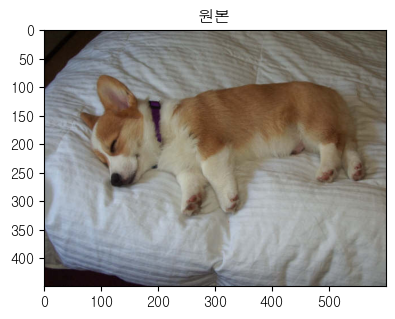

In [ ]:
# 여러 변환작업을 순서대로 적용 - Compose(). 변환할 작업 객체들을 리스트로 순서대로 묶어서 전달.
transform = transforms.Compose([
    # 보통 첫번째 작업으로 지정. 
    # 1. ndarray/PIL.Image -> torch.Tensor, 2.정규화(0 ~ 1), 3. channel first처리((h, w, c)->(c, h, w))
    transforms.ToTensor() 
    ###########################
    # 좌우/상하 반전.  p=반전이 될 확률률
    ###########################
    , transforms.RandomHorizontalFlip(p=0.5)
    , transforms.RandomVerticalFlip(p=0.5)
    
    ###########################
    # 회전 - degrees=회전 각도 : -회전각도 ~ +회전각도 사이로 random 하게 회전.
    ###########################
    # , transforms.RandomRotation(degrees=180) (30, 50)
    
    ###########################
    # affine 이동 변환들
    #  회전, 이동, 전단 변환 처리
    ###########################
    , transforms.RandomAffine(degrees=(-20, 30),       # 회전
                              translate=(0.1,0.3), # 이동 (상하, 좌우) 로 얼만큼 옮길지.(정수: 픽셀, 실수: 이미지 크기대비 비율)
                              shear=(0.8, 1.2),    # 전단변환 (평행사변형 형태로 이동.)
                            #   scale=(0.5,1.2),     # 변환후의 크기(scale)를 조정.
                             )
    
    ###########################
    # 가우시안 블러 - blur (흐리게 만들기. 전처관점-노이즈제거.)
    # kernel_size(고정)와 sigma(랜덤 - 1 ~ 5) 값이 클수로 흐림정도가 강해짐.
    
    ###########################
    , transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1, 5))
    
    ########################### 
    # 선명도 (Sharpen)
    ###########################
    , transforms.RandomAdjustSharpness(sharpness_factor=25, p=0.5) 

    ###########################
    # 색관련 변환
    #  밝기, 대비, 채도, 색 변환 처리
    #  1: 원본과 동일 
    ###########################
    , transforms.ColorJitter(
                            brightness=(0.5, 1.2), # 1 이하: 어둡게, 1이상: 밝게게
                           contrast=(0.8, 1.2),     # 1 이하: 대비를 낮춤. 1이상: 대비를 높이
                           saturation=(0.5, 1.5), # 색농도: 1이하: 색이 흐려짐, 1이상: 색이 강해짐.
                           hue=(-0.2, 0.2)       # 색을 변경: Hue-색과 숫자를 매칭. 숫자를 변경해서 색을 변경.
    )
    
    #########################
    # Grayscale
    #########################
    , transforms.RandomGrayscale(p=0.5)
    
    ############################
    # 반전 - 확률 지정할 수 있다.  255 <-> 0, 254 <-> 1
    ############################
    , transforms.RandomInvert(p=0.7)
    
    
    ###########################
    # Center 영역 Crop - 잘라내기. 잘라낼 크기
    ###########################
    , transforms.CenterCrop(150)
    
    ############################
    # RandomCrop - Crop 영역을 random하게 선택한다.
    ############################
    , transforms.RandomCrop(150)

    ###########################
    # RandomResizedCrop - Random한 영역을 Crop후 지정한 종횡비 resize 한다.
    ###########################
    , transforms.RandomResizedCrop(180, # resize크기(180, 180) -> 모델 입력크기.
                                   scale=(0.3, 0.7), # crop 크기(실수-원래 이미지크기 대비 비율 - 30% ~ 70% 사이로 크롭롭)
                                   ratio=(0.5, 1.5)  # 종횡비(가로세로비율) 변경. (가로비율, 세로비율)
                                  )
    ##############################
    # 이미지를 부분적으로 삭제한다. (픽셀값을 0으로 변경)
    # p=확률, scale=() 삭제 크기범위, ratio=() 삭제 종횡비 범위 => 지정된 튜플 비율에서 random 하게 선택되 변경됨
    # occlusion(폐색-가려지는 문제)문제에서의 한계를 해결. https://deepapple.tistory.com/8
    ###############################
    , transforms.RandomErasing()

])

img_path = 'test_img/image.jpg'
image_show(img_path, transform)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0526534e-06..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0526534e-06..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0526534e-06..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0526935e-06..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000

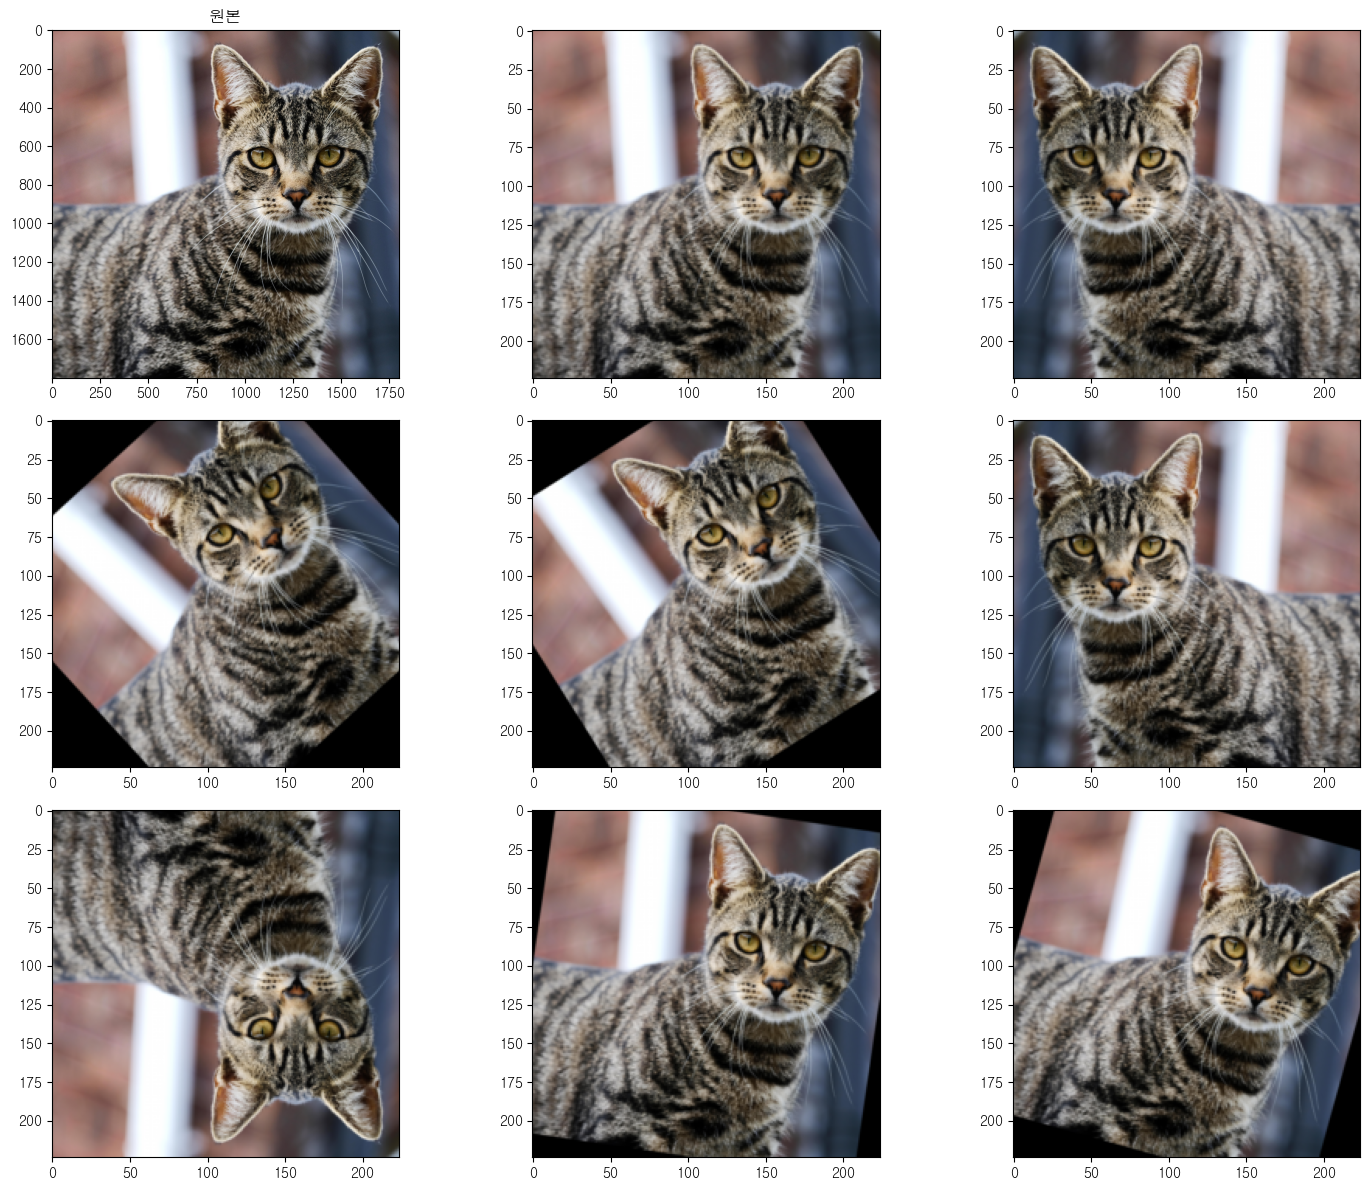

In [40]:
#####################################
# RandomApply() - 여러개 중 Random하게 여러개를 선택해서 적용한다. 선택 확률을 선택할 수 있다.
# RandomChoice() - 여러개 중 하나를 적용한다.
#####################################
# transform2 = transforms.Compose([
#     transforms.ToTensor()
#     , transforms.RandomApply([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(45), 
#         transforms.RandomCrop((200,200)),
#     ], p = 0.5)
#     , transforms.Resize((224, 224), antialias=True)
# ])

transform2 = transforms.Compose([
    transforms.ToTensor()
    , transforms.RandomChoice([
        transforms.RandomRotation(45), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ])
    , transforms.Resize((224, 224), antialias=True)
])

image_show('test_img/cat.jpg', transform2)